# Electricity Demand Analysis

In [1]:
%load_ext autoreload
%autoreload 2

# Standard Python
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NEM-TEL and BOM-Data modules
from nemtel.tracker import NEM_tracker
from nemtel.extractor import NEM_extractor
from nemtel.loader import NEM_loader
from bomdata.scraper import BOM_scraper

# Other
from __common__ import user_choice
from helper import parse_weather_data, normalize_series  

# Configuration
import config
config.use('config.json')

Value for NEM_PATH has been set!
Value for BOM_PATH has been set!


## NEM-TEL: Track, Extract, Load
***
### Resource Tracking

* running `.bulk_update()` extracts the latest data file URLs for all currently tracked resources

In [2]:
nem_dir = os.getenv('NEM_PATH')
nem_trk = NEM_tracker(nem_dir)
nem_trk.bulk_update()

### Resource Extraction

* here we identify the data files that have not yet been downloaded from a selected resource 
  * the files selected for download can be accessed via the `.download_df` attribute

In [3]:
nem_get = NEM_extractor(nem_dir)
nem_get.load_tracker_df()
nem_get.adjust_time_range(date_min='2020-04-01')
nem_get.set_download_df(by_time_range=True)
nem_get.download_df

[0] /Reports/Current/Operational_Demand/ACTUAL_DAILY/
[1] /Reports/Current/Dispatch_SCADA/
[2] /Reports/Current/Next_Day_Intermittent_DS/
[3] /Reports/Archive/Operational_Demand/Actual_Daily/

Selected: /Reports/Current/Operational_Demand/ACTUAL_DAILY/


,TIMESTAMP,VERSION,DOWNLOADED,DOWNLOAD_DATE,URL
57,2020-04-15,V20200416044000,False,1900-01-01,http://nemweb.com.au/Reports/Current/Operation...
58,2020-04-16,V20200417044001,False,1900-01-01,http://nemweb.com.au/Reports/Current/Operation...
59,2020-04-17,V20200418044001,False,1900-01-01,http://nemweb.com.au/Reports/Current/Operation...


Run `.download_files()` to download all the files listed in  `.download_df`.

In [4]:
nem_get.download_files()

### Resource Loader

To analyse electricity demand over a longer period of time, we need to combine both "Current" and "Archive" data files.

In [5]:
nem_load = NEM_loader(nem_dir)
res_dict = dict(enumerate(nem_load.resources.keys()))
res_dict

{0: '/Reports/Current/Operational_Demand/ACTUAL_DAILY/',
 1: '/Reports/Current/Dispatch_SCADA/',
 2: '/Reports/Current/Next_Day_Intermittent_DS/',
 3: '/Reports/Archive/Operational_Demand/Actual_Daily/'}

All the data is aggregated into the `data` dictionary.

In [6]:
data = {}
for i in [0, 3]:
    nem_load.select_resource (res_dict[i])
    nem_load.get_available_files()
    nem_load.set_read_list(all_files=True)
    data.update(nem_load.process_read_list())

## BOM Data Extraction
***
### Loading downloaded weather data

* Station `"IDCJDW2124"` is Sydney's main weather station. 
* The BOM historical data only has 9AM and 3PM readings, but I make the assumption that:
  * The minimum temperature occurs at 5AM
  * The maximum temperature occurs at 1PM

In [7]:
bom_dir = os.getenv('BOM_PATH')
bom_ws = BOM_scraper(bom_dir)
bom_ws.set_station_id("IDCJDW2124")
bom_ws.scrape_station()
bom_ws.download_files(dates=['Apr-20'])
bom_df = bom_ws.load_station_data()
keep_cols = ['Date', 'Minimum temperature (°C)', 'Maximum temperature (°C)',
             '9am Temperature (°C)', '9am relative humidity (%)', 
             '3pm Temperature (°C)', '3pm relative humidity (%)']
bom_df = bom_df[keep_cols]
bom_df.columns = ['Date', 'TEMP_05:00', 'TEMP_13:00',
                  'TEMP_09:00', 'HUMID_09:00', 'TEMP_15:00', 'HUMID_15:00']                  
bom_df.head()   

,Date,TEMP_05:00,TEMP_13:00,TEMP_09:00,HUMID_09:00,TEMP_15:00,HUMID_15:00
0,2019-03-1,21.0,28.1,23.2,67,27.7,53.0
1,2019-03-2,20.2,27.9,23.0,70,26.5,53.0
2,2019-03-3,20.3,27.9,23.8,67,26.7,55.0
3,2019-03-4,21.8,28.2,25.6,59,27.7,54.0
4,2019-03-5,21.9,28.6,24.5,63,27.5,56.0


### Parsing weather data

The BOM data needs to reformatted so that it can be merged with AEMO data.

In [8]:
temp_df, humid_df = [parse_weather_data(bom_df, s)
                     for s in ['TEMP', 'HUMID']]
display(temp_df.tail())
display(humid_df.tail())

,TEMP,TIMESTAMP
1243,21.1,2020-04-17 09:00:00
828,28.1,2020-04-17 13:00:00
1658,27.5,2020-04-17 15:00:00
414,13.8,2020-04-18 05:00:00
1244,16.4,2020-04-18 09:00:00


,HUMID,TIMESTAMP
412,55.0,2020-04-16 09:00:00
827,45.0,2020-04-16 15:00:00
413,40.0,2020-04-17 09:00:00
828,15.0,2020-04-17 15:00:00
414,50.0,2020-04-18 09:00:00


## Exploratory Data Analysis
***
### Pre-processing

In [9]:
demand_df = pd.concat([v[0] for v in data.values()])
demand_df = demand_df[['INTERVAL_DATETIME','REGIONID','OPERATIONAL_DEMAND.1']]
demand_df.columns = ['TIMESTAMP','STATE','DEMAND']
demand_df.loc[:, 'TIMESTAMP'] = pd.to_datetime(demand_df['TIMESTAMP'])
demand_df = demand_df.sort_values(by=['STATE', 'TIMESTAMP'])
demand_df.head()

,TIMESTAMP,STATE,DEMAND
0,2019-02-01 04:30:00,NSW1,6976
1,2019-02-01 05:00:00,NSW1,7213
2,2019-02-01 05:30:00,NSW1,7653
3,2019-02-01 06:00:00,NSW1,8013
4,2019-02-01 06:30:00,NSW1,8369


### Basic visual

A few takeaways from here:
* ...

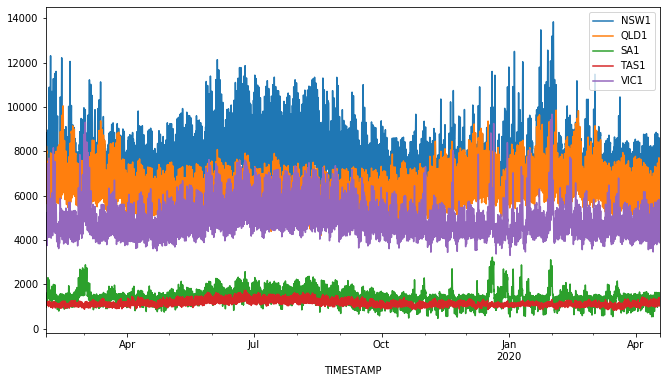

In [10]:
grp_df = demand_df.set_index('TIMESTAMP').groupby('STATE')['DEMAND']
grp_df.plot(legend=True, figsize=(11,6))
plt.show()

### Focusing on a state / smaller timeframe

In [11]:
state = user_choice(demand_df['STATE'].unique())
state_df = demand_df.copy()[demand_df['STATE']==state].drop('STATE',1)

[0] NSW1
[1] QLD1
[2] SA1
[3] TAS1
[4] VIC1

Selected: NSW1


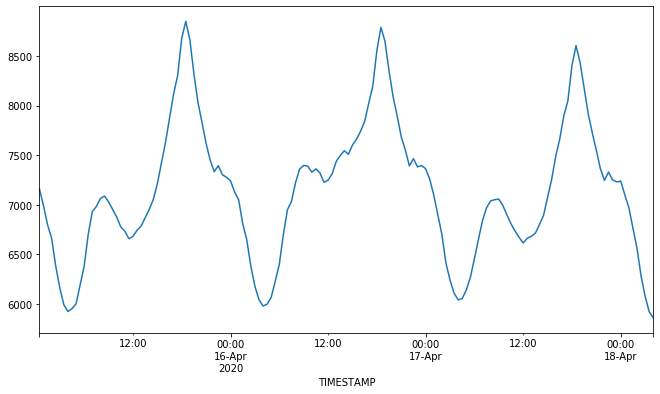

In [12]:
fig_df = state_df.copy()[state_df['TIMESTAMP'] > '2020-04-15']
fig_df.set_index('TIMESTAMP')['DEMAND'].plot(figsize=(11,6))
plt.show()

### Extracting more information

In [13]:
state_df.loc[:,'HOUR'] = state_df.TIMESTAMP.apply(lambda x: x.hour)
state_df.loc[:,'DAY'] = state_df.TIMESTAMP.apply(lambda x: x.day_name())
state_df.loc[:,'WEEKEND'] = state_df.DAY.isin(['Saturday', 'Sunday'])
state_df.head()

,TIMESTAMP,DEMAND,HOUR,DAY,WEEKEND
0,2019-02-01 04:30:00,6976,4,Friday,False
1,2019-02-01 05:00:00,7213,5,Friday,False
2,2019-02-01 05:30:00,7653,5,Friday,False
3,2019-02-01 06:00:00,8013,6,Friday,False
4,2019-02-01 06:30:00,8369,6,Friday,False


### The weekend effect

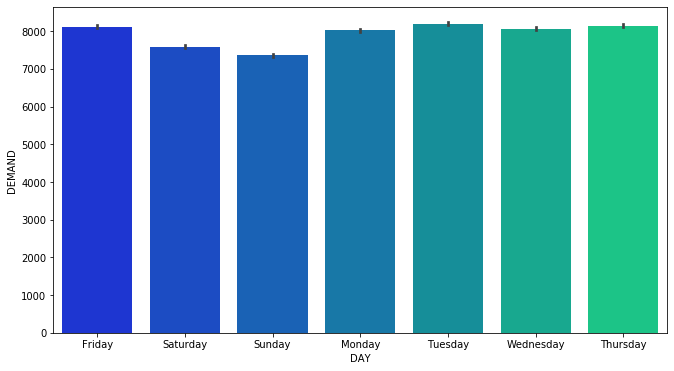

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(11,6))
ax = sns.barplot(x="DAY", y="DEMAND", data=state_df, palette='winter')
plt.show()

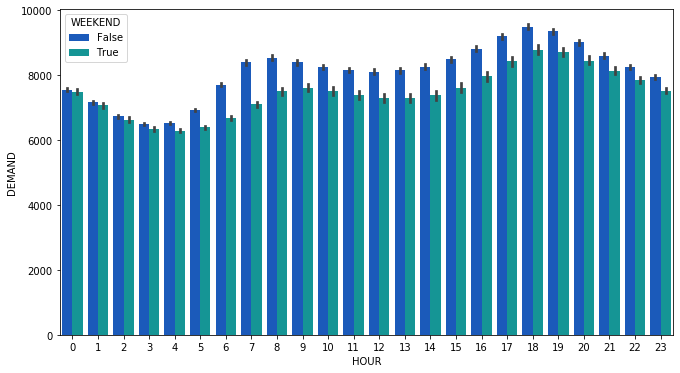

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(11,6))
ax = sns.barplot(x="HOUR", y="DEMAND", hue='WEEKEND', data=state_df, palette='winter')
plt.show()

### Add Weather Data

In [16]:
full_df = state_df.merge(temp_df, on='TIMESTAMP', how='left'
                 ).merge(humid_df, on='TIMESTAMP', how='left')
full_df.loc[:,'TEMP'] = full_df['TEMP'].interpolate(method='linear')
full_df.loc[:,'HUMID'] = full_df['HUMID'].interpolate(method='linear')
full_df = full_df.dropna()
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19863 entries, 1353 to 21215
Data columns (total 7 columns):
TIMESTAMP    19863 non-null datetime64[ns]
DEMAND       19863 non-null int64
HOUR         19863 non-null int64
DAY          19863 non-null object
WEEKEND      19863 non-null bool
TEMP         19863 non-null float64
HUMID        19863 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 1.1+ MB


In [17]:
full_df.corr()

,DEMAND,HOUR,WEEKEND,TEMP,HUMID
DEMAND,1.000000,0.495439,-0.233797,0.106692,-0.056889
HOUR,0.495439,1.000000,-0.001627,0.275893,-0.148527
WEEKEND,-0.233797,-0.001627,1.000000,-0.027901,0.012096
TEMP,0.106692,0.275893,-0.027901,1.000000,-0.119872
HUMID,-0.056889,-0.148527,0.012096,-0.119872,1.000000


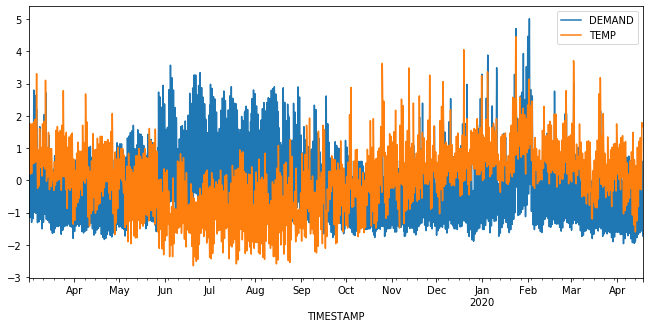

In [18]:
fig_df = full_df.set_index('TIMESTAMP')[['DEMAND','TEMP']]
for col in fig_df.columns:
    fig_df[col] = normalize_series(fig_df[col])
fig_df.plot(figsize=(11,5))
plt.show()

### Weather buckets

In [19]:
full_df.loc[:, 'TEMP_CAT'] = pd.cut(full_df.TEMP, 4, labels=['cold', 'mild', 'warm', 'hot'])
full_df.loc[:, 'HUMID_CAT'] = pd.cut(full_df.HUMID, 3, labels=['dry', 'normal', 'humid'])
full_df.groupby('TEMP_CAT').TEMP.mean()

TEMP_CAT
cold    12.198353
mild    19.620380
warm    25.932935
hot     34.981585
Name: TEMP, dtype: float64

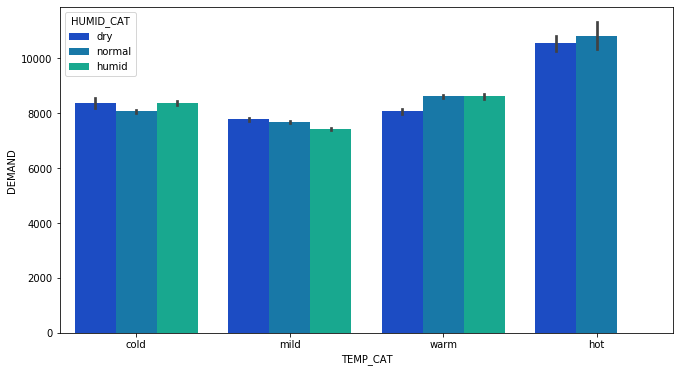

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(11,6))
ax = sns.barplot(x="TEMP_CAT", y="DEMAND", hue="HUMID_CAT", data=full_df, palette='winter')
plt.show()